# Spectral analysis

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

import drifters.utils as ut
import pynsitu as pin
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

from GDP_lib import (
    noise_traj,
    negpos_spectra,
    psd_white_noise,
    psd_centered_der,
    psd_uncentered_der,
    var_centered_der,
    var_2uncentered_der,
)

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.111:8787/status,
Dashboard: http://10.148.0.111:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.111:34246,Workers: 0
Dashboard: http://10.148.0.111:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# LOAD

In [3]:
root_dir = "/home1/datawork/mdemol/GDP"
"""
key2 = ""
zarr_argos = os.path.join(root_dir, "argos_geospectra_2" + key2 + ".zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsa = xr.open_zarr(zarr_argos).persist()
"""

key2 = "_corrected"
zarr_argos = os.path.join(root_dir, "argos_geospectra_2" + key2 + ".zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsgc = xr.open_zarr(zarr_gps)
dsac = xr.open_zarr(zarr_argos)

# Sum cyclonic and anticyclonic spectrum
neg, pos = negpos_spectra(dsgc)
dsgc = (neg + pos).persist()
neg, pos = negpos_spectra(dsac)
dsac = (neg + pos).persist()

In [4]:
c = ["gold", "palegreen", "green", "olivedrab", "darkgreen"]

## Testing different level

In [5]:
def noise(freq, stdnx):
    def _noise(freq, stdnx):
        psdx = psd_white_noise(freq, stdnx, D=2).rename("psd_nx")
        psdvxy = psd_centered_der(psdx, freq="frequency").rename("psd_nv")
        psdvxy_unc = psd_uncentered_der(psdx, freq="frequency")
        psdaxy = psd_uncentered_der(psdvxy_unc, freq="frequency").rename("psd_na")
        ds = xr.merge([psdx, psdvxy, psdaxy])
        ds["stdnx"] = stdnx
        return ds

    if not isinstance(stdnx, float):
        D = []
        for stdi in stdnx:
            D.append(_noise(freq, stdi))
        ds = xr.concat(D, dim="stdnx")
        ds["stdnv"] = np.sqrt(var_centered_der(ds.stdnx, D=2))
        ds["stdna"] = np.sqrt(var_2uncentered_der(ds.stdnx, D=2))
        return ds
    else:
        return _noise(freq, stdnx)

In [6]:
freq = dsgc.frequency.compute()
noiseg = [25, 35, 45, 65]
noisea = [150, 200, 250, 300]
dsng = noise(freq, noiseg)
dsna = noise(freq, noisea)

In [7]:
dsng

<xarray.Dataset>
Dimensions:    (frequency: 720, stdnx: 4)
Coordinates:
  * frequency  (frequency) float64 -0.0 0.01667 0.03333 ... 11.95 11.97 11.98
  * stdnx      (stdnx) int64 25 35 45 65
Data variables:
    psd_nx     (stdnx, frequency) float64 104.3 104.3 104.3 ... 705.1 705.1
    psd_nv     (stdnx, frequency) float64 0.0 1.532e-10 ... 4.143e-09 1.036e-09
    psd_na     (stdnx, frequency) float64 0.0 2.251e-22 ... 6.717e-11 6.717e-11
    stdnv      (stdnx) float64 0.006944 0.009722 0.0125 0.01806
    stdna      (stdnx) float64 6.682e-06 9.355e-06 1.203e-05 1.737e-05

Text(0.5, 1.0, 'Argos')

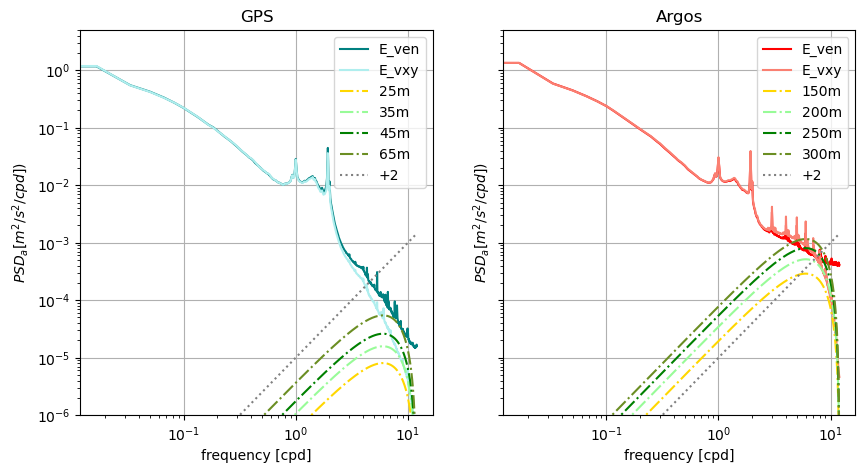

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax = ax.flatten()

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="teal", ax=ax[0]
)  # , alpha=0.5)
dsgc.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="paleturquoise", ax=ax[0]
)  # , alpha=0.5)
# dsng.psd_nv.plot(hue='stdx', ax=ax[0], ls="-.")

dsac.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="red", ax=ax[1]
)  # , alpha=0.5)
dsac.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="salmon", ax=ax[1]
)  # , alpha=0.5)
# dsna.psd_nv.plot(hue='stdx', ax=ax[1], ls="-.")

for i in range(len(dsng.stdnx)):
    dsng.psd_nv.isel(stdnx=i).plot(
        ax=ax[0], ls="-.", color=c[i], label=f"{int(dsng.stdnx.isel(stdnx=i))}m"
    )

for i in range(len(dsng.stdnx)):
    dsna.psd_nv.isel(stdnx=i).plot(
        ax=ax[1], ls="-.", color=c[i], label=f"{int(dsna.stdnx.isel(stdnx=i))}m"
    )

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")

    a.set_xscale("log")
    a.set_yscale("log")
    # (1 / dsac.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color = 'k')
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls="--", color = 'grey')
    (dsac.frequency**2 * 1e-5).plot(ax=a, label="+2", ls=":", color="grey")
    a.legend()
    a.set_ylim((1e-6, 5))
    a.set_ylabel(r"$PSD_a[m^2/s^2/cpd]$)")

ax[0].set_title("GPS")
ax[1].set_title("Argos")

Text(0.5, 1.0, 'Argos')

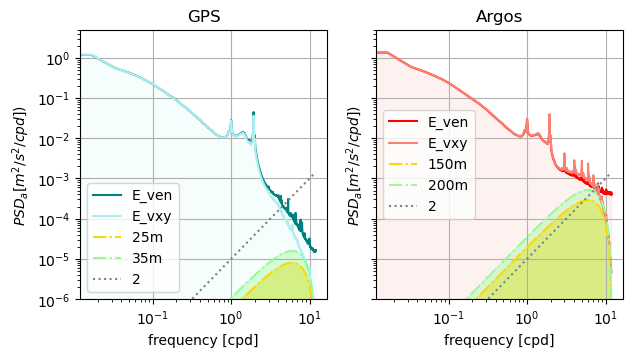

In [9]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 3.5))
ax = ax.flatten()

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="teal", ax=ax[0]
)  # , alpha=0.5)
dsgc.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="paleturquoise", ax=ax[0]
)  # , alpha=0.5)
ax[0].fill_between(
    freq, dsgc.E_ven.mean(["lon_bins", "lat_bins"]), color="paleturquoise", alpha=0.1
)

dsac.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="red", ax=ax[1]
)  # , alpha=0.5)
dsac.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="salmon", ax=ax[1]
)  # , alpha=0.5)
ax[1].fill_between(
    freq, dsac.E_ven.mean(["lon_bins", "lat_bins"]), color="salmon", alpha=0.1
)

for i in range(2):
    dsng.psd_nv.isel(stdnx=i).plot(
        ax=ax[0], ls="-.", color=c[i], label=f"{int(dsng.stdnx.isel(stdnx=i))}m"
    )
    ax[0].fill_between(
        freq, dsng.psd_nv.isel(stdnx=i), color=c[i], alpha=0.5 - 2 * i / 15
    )
for i in range(2):
    dsna.psd_nv.isel(stdnx=i).plot(
        ax=ax[1], ls="-.", color=c[i], label=f"{int(dsna.stdnx.isel(stdnx=i))}m"
    )
    ax[1].fill_between(
        freq, dsna.psd_nv.isel(stdnx=i), color=c[i], alpha=0.5 - 2 * i / 15
    )

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")

    a.set_xscale("log")
    a.set_yscale("log")
    # (1 / dsac.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color = 'k')
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls="--", color = 'grey')
    (dsac.frequency**2 * 1e-5).plot(ax=a, label="2", ls=":", color="grey")
    a.legend()
    a.set_ylim((1e-6, 5))
    a.set_ylabel(r"$PSD_a[m^2/s^2/cpd]$)")

ax[0].set_title("GPS")
ax[1].set_title("Argos")

Text(0.5, 1.0, 'Argos')

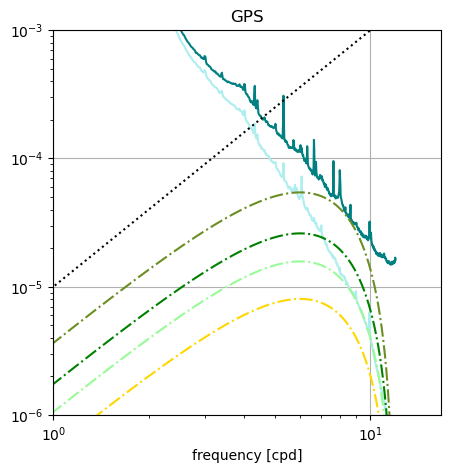

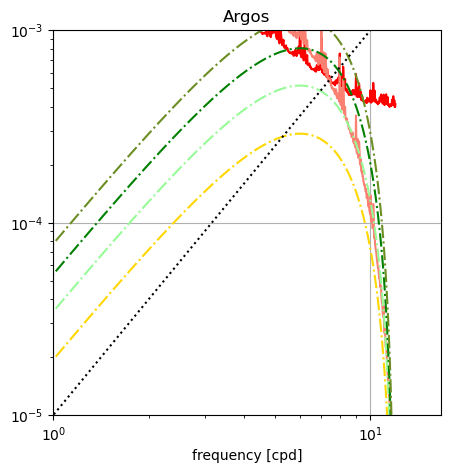

In [10]:
fig, a = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="teal", ax=a
)  # , alpha=0.5)
dsgc.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="paleturquoise", ax=a
)  # , alpha=0.5)
for i in range(len(dsng.stdnx)):
    dsng.psd_nv.isel(stdnx=i).plot(
        ls="-.", color=c[i], label=f"{int(dsng.stdnx.isel(stdnx=i))}m", ax=a
    )
a.grid()
a.set_xlabel("Frequency [cpd]")

a.set_xscale("log")
a.set_yscale("log")
(dsac.frequency**2 * 1e-5).plot(ax=a, label="2", ls=":", color="k")
# a.legend()
a.set_ylim((1e-6, 1e-3))
a.set_xlim(1)
a.set_title("GPS")
a.set_ylabel(r"")


fig, a = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

dsac.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="red", ax=a
)  # , alpha=0.5)
dsac.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="salmon", ax=a
)  # , alpha=0.5)

for i in range(len(dsna.stdnx)):
    dsna.psd_nv.isel(stdnx=i).plot(
        ax=a, ls="-.", color=c[i], label=f"{int(dsna.stdnx.isel(stdnx=i))}m"
    )

a.grid()
a.set_xlabel("Frequency [cpd]")

a.set_xscale("log")
a.set_yscale("log")
(dsac.frequency**2 * 1e-5).plot(ax=a, label="2", ls=":", color="k")
# a.legend()
a.set_ylim((1e-5, 1e-3))
a.set_xlim(1)
a.set_ylabel("")

a.set_title("Argos")

# Parseval on noise

In [11]:
dsng

<xarray.Dataset>
Dimensions:    (frequency: 720, stdnx: 4)
Coordinates:
  * frequency  (frequency) float64 -0.0 0.01667 0.03333 ... 11.95 11.97 11.98
  * stdnx      (stdnx) int64 25 35 45 65
Data variables:
    psd_nx     (stdnx, frequency) float64 104.3 104.3 104.3 ... 705.1 705.1
    psd_nv     (stdnx, frequency) float64 0.0 1.532e-10 ... 4.143e-09 1.036e-09
    psd_na     (stdnx, frequency) float64 0.0 2.251e-22 ... 6.717e-11 6.717e-11
    stdnv      (stdnx) float64 0.006944 0.009722 0.0125 0.01806
    stdna      (stdnx) float64 6.682e-06 9.355e-06 1.203e-05 1.737e-05

In [20]:
print(dsna.psd_nv.integrate("frequency").compute(), dsna.stdnv.compute() ** 2)

<xarray.DataArray 'psd_nv' (stdnx: 4)>
array([0.00173853, 0.00309071, 0.00482924, 0.0069541 ])
Coordinates:
  * stdnx    (stdnx) int64 150 200 250 300 <xarray.DataArray 'stdnv' (stdnx: 4)>
array([0.00173611, 0.00308642, 0.00482253, 0.00694444])
Coordinates:
  * stdnx    (stdnx) int64 150 200 250 300


In [13]:
print(dsna.psd_na.integrate("frequency").compute(), dsna.stdna.compute() ** 2)

<xarray.DataArray 'psd_na' (stdnx: 4)>
array([1.60378405e-09, 2.85117165e-09, 4.45495570e-09, 6.41513621e-09])
Coordinates:
  * stdnx    (stdnx) int64 150 200 250 300 <xarray.DataArray 'stdna' (stdnx: 4)>
array([1.60751029e-09, 2.85779607e-09, 4.46530636e-09, 6.43004115e-09])
Coordinates:
  * stdnx    (stdnx) int64 150 200 250 300


## Pourcentage of white noise

In [16]:
totg = (
    dsgc.mean(["lon_bins", "lat_bins"])
    .integrate("frequency")[["E_ven", "E_vxy"]]
    .compute()
)
tota = (
    dsac.mean(["lon_bins", "lat_bins"])
    .integrate("frequency")[["E_ven", "E_vxy"]]
    .compute()
)
var_noise_g = np.array(dsng.stdnv**2)
var_noise_a = np.array(dsna.stdnv**2)
print(f"GPS : stdx {noiseg}")
print(f"GPS : var_noise/ven2 {var_noise_g/float(totg.E_ven)*100}")
print(f"GPS : var_noise/vxy2 {var_noise_g/float(totg.E_vxy)*100}")
print(f"Argos : stdx {noisea}")
print(f"Argos: var_noise/ven2 {var_noise_a/float(tota.E_ven)*100}")
print(f"Argos : var_noise/vxy2 {var_noise_a/float(tota.E_vxy)*100}")

GPS : stdx [25, 35, 45, 65]
GPS : var_noise/ven2 [0.04145723 0.08125617 0.13432142 0.28025087]
GPS : var_noise/vxy2 [0.04178557 0.08189973 0.13538526 0.28247049]
Argos : stdx [150, 200, 250, 300]
Argos: var_noise/ven2 [1.31335935 2.33486107 3.64822043 5.25343742]
Argos : var_noise/vxy2 [1.30790779 2.3251694  3.63307719 5.23163115]


_______
# Acceleration

Text(0.5, 1.0, 'Argos')

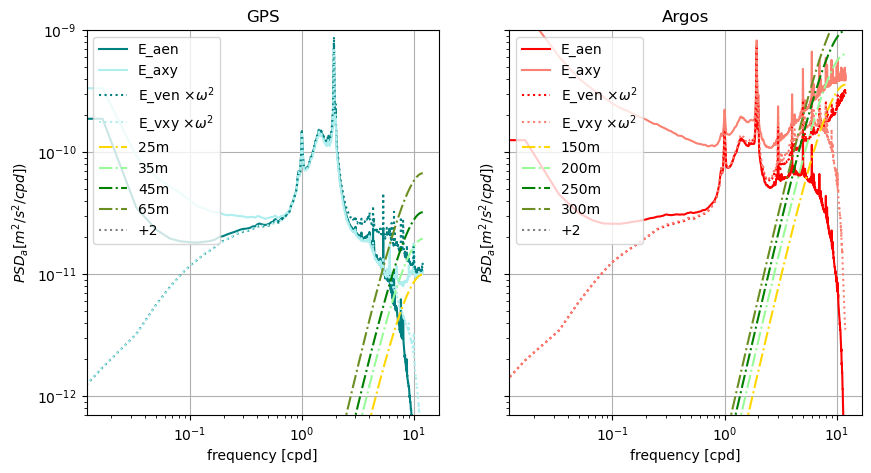

In [24]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax = ax.flatten()

dsgc.E_aen.mean(["lon_bins", "lat_bins"]).plot(
    label="E_aen", color="teal", ax=ax[0]
)  # , alpha=0.5)
dsgc.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="paleturquoise", ax=ax[0]
)  # , alpha=0.5)
# dsng.psd_nv.plot(hue='stdx', ax=ax[0], ls="-.")
dsgc.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="teal", ls=":", ax=ax[0]
)
dsgc.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="paleturquoise", ls=":", ax=ax[0]
)

dsac.E_aen.mean(["lon_bins", "lat_bins"]).plot(
    label="E_aen", color="red", ax=ax[1]
)  # , alpha=0.5)
dsac.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="salmon", ax=ax[1]
)  # , alpha=0.5)
# dsna.psd_nv.plot(hue='stdx', ax=ax[1], ls="-.")
dsac.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[1]
)
dsac.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[1]
)

for i in range(len(dsng.stdnx)):
    dsng.psd_na.isel(stdnx=i).plot(
        ax=ax[0], ls="-.", color=c[i], label=f"{int(dsng.stdnx.isel(stdnx=i))}m"
    )

for i in range(len(dsng.stdnx)):
    dsna.psd_na.isel(stdnx=i).plot(
        ax=ax[1], ls="-.", color=c[i], label=f"{int(dsna.stdnx.isel(stdnx=i))}m"
    )

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")

    a.set_xscale("log")
    a.set_yscale("log")
    # (1 / dsac.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color = 'k')
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls="--", color = 'grey')
    (dsac.frequency**2 * 1e-5).plot(ax=a, label="+2", ls=":", color="grey")
    a.legend()
    a.set_ylim(7 * 1e-13, 1e-9)
    a.set_ylabel(r"$PSD_a[m^2/s^2/cpd]$)")

ax[0].set_title("GPS")
ax[1].set_title("Argos")

Text(0.5, 1.0, 'Argos')

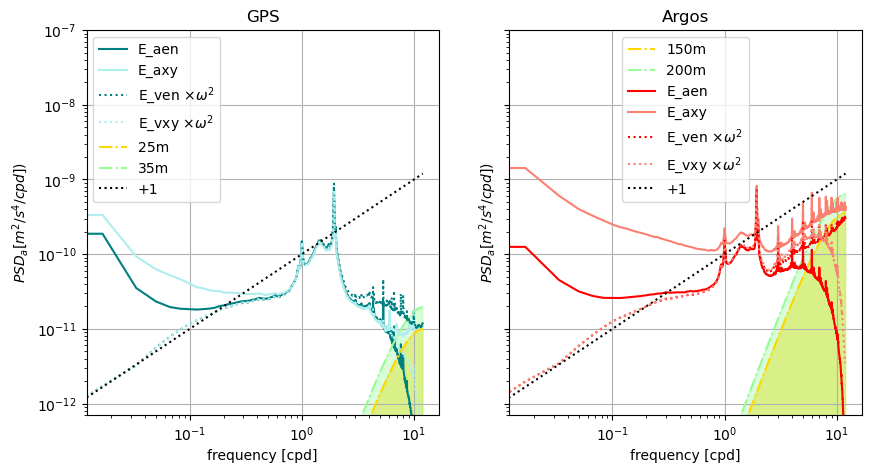

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax = ax.flatten()

dsgc.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="teal", ax=ax[0])
dsgc.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="paleturquoise", ax=ax[0]
)
# dsgc.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_avxy", color="b", ax=ax[0])
dsgc.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="teal", ls=":", ax=ax[0]
)
dsgc.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="paleturquoise", ls=":", ax=ax[0]
)
for i in range(2):
    dsng.psd_na.isel(stdnx=i).plot(
        ax=ax[0], ls="-.", color=c[i], label=f"{int(dsng.stdnx.isel(stdnx=i))}m"
    )
    ax[0].fill_between(
        freq, dsng.psd_na.isel(stdnx=i), color=c[i], alpha=0.5 - 2 * i / 15
    )
for i in range(2):
    dsna.psd_na.isel(stdnx=i).plot(
        ax=ax[1], ls="-.", color=c[i], label=f"{int(dsna.stdnx.isel(stdnx=i))}m"
    )
    ax[1].fill_between(
        freq, dsna.psd_na.isel(stdnx=i), color=c[i], alpha=0.5 - 2 * i / 15
    )

dsac.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="red", ax=ax[1])
dsac.E_axy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="salmon", ax=ax[1])
# dsac.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="teal", ax=ax[1])
dsac.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[1]
)
dsac.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[1]
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (dsac.frequency.isel(frequency=slice(0, 725)) * 1e-10).plot(
        ax=a, label="+1", ls=":", color="k"
    )
    # (dsac.frequency.isel(frequency= slice(0,725))**0 * 1e-10).plot(ax=a, label="+1", ls=":", color='k')
    # (dsac.frequency**4 * 1e-9).plot(ax=a, label="+4", ls="--")
    a.legend()
    a.set_ylim(7 * 1e-13, 1e-9)
    a.set_ylabel(r"$PSD_a [m^2/s^4/cpd]$)")
ax[0].set_title("GPS")
ax[1].set_title("Argos")

Text(0.5, 1.0, 'Argos')

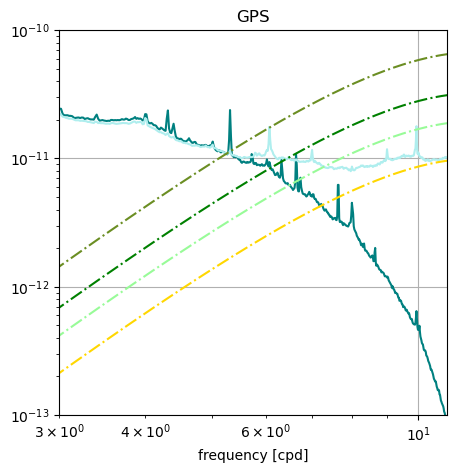

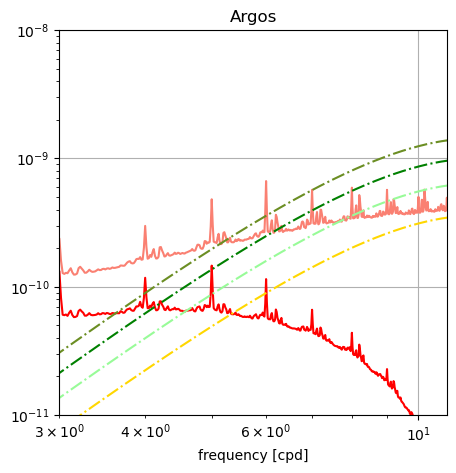

In [20]:
fig, a = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

dsgc.E_aen.mean(["lon_bins", "lat_bins"]).plot(
    label="E_aen", color="teal", ax=a
)  # , alpha=0.5)
dsgc.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="paleturquoise", ax=a
)  # , alpha=0.5)
for i in range(len(dsng.stdnx)):
    dsng.psd_na.isel(stdnx=i).plot(
        ls="-.", color=c[i], label=f"{int(dsng.stdnx.isel(stdnx=i))}m", ax=a
    )
a.grid()
a.set_xlabel("Frequency [cpd]")

a.set_xscale("log")
a.set_yscale("log")
(dsac.frequency**2 * 1e-5).plot(ax=a, label="2", ls=":", color="k")
# a.legend()
a.set_ylim((1e-13, 1e-10))
a.set_xlim(3, 11)
a.set_title("GPS")
a.set_ylabel(r"")


fig, a = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

dsac.E_aen.mean(["lon_bins", "lat_bins"]).plot(
    label="E_aen", color="red", ax=a
)  # , alpha=0.5)
dsac.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="salmon", ax=a
)  # , alpha=0.5)

for i in range(len(dsna.stdnx)):
    dsna.psd_na.isel(stdnx=i).plot(
        ax=a, ls="-.", color=c[i], label=f"{int(dsna.stdnx.isel(stdnx=i))}m"
    )

a.grid()
a.set_xlabel("Frequency [cpd]")

a.set_xscale("log")
a.set_yscale("log")
(dsac.frequency**2 * 1e-5).plot(ax=a, label="2", ls=":", color="k")
# a.legend()
a.set_ylim((1e-11, 1e-8))
a.set_xlim(3, 11)
a.set_ylabel("")

a.set_title("Argos")

## Pourcentage of white noise

In [12]:
totg = (
    dsgc.mean(["lon_bins", "lat_bins"])
    .integrate("frequency")[["E_aen", "E_axy"]]
    .compute()
)
tota = (
    dsac.mean(["lon_bins", "lat_bins"])
    .integrate("frequency")[["E_aen", "E_axy"]]
    .compute()
)
dt = 3600
var_noise_g = np.array(dsng.stdna**2)
var_noise_a = np.array(dsna.stdna**2)
print(f"GPS : stdx {noiseg}")
print(f"GPS : var_noise/aen2 {var_noise_g/float(totg.E_aen)*100}")
print(f"GPS : var_noise/axy2 {var_noise_g/float(totg.E_axy)*100}")
print(f"Argos : stdx {noisea}")
print(f"Argos: var_noise/aen2 {var_noise_a/float(tota.E_aen)*100}")
print(f"Argos : var_noise/axy2 {var_noise_a/float(tota.E_axy)*100}")

GPS : stdx [25, 35, 45, 65]
GPS : var_noise/aen2 [ 15.67307795  30.71923277  50.78077254 105.95000691]
GPS : var_noise/axy2 [13.69116863 26.83469051 44.35938636 92.55229993]
Argos : stdx [150, 200, 250, 300]
Argos: var_noise/aen2 [ 284.12534605  505.11172632  789.23707237 1136.50138422]
Argos : var_noise/axy2 [ 48.36964832  85.9904859  134.36013422 193.47859328]


In [25]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min